# Importing Libraries

In [1]:
import tensorflow as tf
import pathlib
import PIL.Image
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import layers, models
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Flatten, SimpleRNN

# Loading and preprocessing of data

In [2]:
train_set_dir = 'D:/apps/apple_disease_dataset/train'

In [3]:
valid_set_dir = 'D:/apps/apple_disease_dataset/valid'

In [4]:
test_set_dir = 'D:/apps/apple_disease_dataset/test'

In [5]:
X_train = []
for dir_ in os.listdir(train_set_dir):
    inner_dir = train_set_dir + "/" + dir_
    for img in os.listdir(inner_dir):
        img_path = inner_dir + "/" +img
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, (224, 224))
        X_train.append(img_arr)

In [6]:
X_valid = []
for dir_ in os.listdir(valid_set_dir):
    inner_dir = valid_set_dir + "/" + dir_
    for img in os.listdir(inner_dir):
        img_path = inner_dir + "/" +img
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, (224, 224))
        X_valid.append(img_arr)

In [7]:
x_train = np.array(X_train)
x_valid = np.array(X_valid)
print(len(x_train))
print(len(x_valid))

7771
1943


In [8]:
normalise_data = ImageDataGenerator(rescale = 1./255)    

In [9]:
Y_train = normalise_data.flow_from_directory(train_set_dir, target_size = (224, 224), batch_size = 32, class_mode = 'sparse')

Found 7771 images belonging to 4 classes.


In [10]:
Y_train.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}

In [11]:
classes = ["Apple___Apple_scab", "Apple___Black_rot", "Apple___Cedar_apple_rust", "Apple___healthy"]
classes = np.array(classes)
print(classes)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy']


In [12]:
Y_valid = normalise_data.flow_from_directory(valid_set_dir, target_size = (224, 224), batch_size = 32, class_mode = 'sparse')

Found 1943 images belonging to 4 classes.


In [13]:
y_train = Y_train.classes

In [14]:
y_valid = Y_valid.classes

In [15]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_valid = np_utils.to_categorical(lb.fit_transform(y_valid))

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(7771, 224, 224, 3)
(7771, 4)
(1943, 224, 224, 3)
(1943, 4)


# Training the model

In [17]:
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
vgg_model.trainable = False

In [18]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [45]:
model = models.Sequential([
    vgg_model,
#     layers.Flatten(),
#     layers.Dense(50, activation='relu'),
#     layers.Dense(20, activation='relu'),
#     layers.Dense(4, activation='softmax')
    layers.TimeDistributed(Flatten()),
    layers.SimpleRNN(64, return_sequences = False ),  
    layers.Dense(20, activation='relu'),
    layers.Dense(4, activation='softmax')
#     layers.SimpleRNN(32, return_sequences = True),
#     layers.SimpleRNN(4, return_sequences = False)
])

In [46]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
time_distributed_6 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 64)                233536    
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1300      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 84        
Total params: 14,949,608
Trainable params: 234,920
Non-trainable params: 14,714,688
_________________________________________________________________


In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
vgg_history = model.fit(x_train,y_train, epochs=25, validation_data=(x_valid,y_valid), batch_size=32)

Epoch 1/25
243/243 [==============================] - 2736s 11s/step - loss: 0.6478 - accuracy: 0.7533 - val_loss: 0.4138 - val_accuracy: 0.8451
Epoch 2/25
243/243 [==============================] - 1872s 8s/step - loss: 0.4000 - accuracy: 0.8523 - val_loss: 0.3992 - val_accuracy: 0.8543
Epoch 3/25
243/243 [==============================] - 1713s 7s/step - loss: 0.3375 - accuracy: 0.8801 - val_loss: 0.4169 - val_accuracy: 0.8507
Epoch 4/25
243/243 [==============================] - 1743s 7s/step - loss: 0.3028 - accuracy: 0.8928 - val_loss: 0.3441 - val_accuracy: 0.8734
Epoch 5/25
243/243 [==============================] - 1732s 7s/step - loss: 0.2743 - accuracy: 0.9027 - val_loss: 0.3716 - val_accuracy: 0.8657
Epoch 6/25
243/243 [==============================] - 1656s 7s/step - loss: 0.2657 - accuracy: 0.9036 - val_loss: 0.3603 - val_accuracy: 0.8734
Epoch 7/25
243/243 [==============================] - 2130s 9s/step - loss: 0.2549 - accuracy: 0.9064 - val_loss: 0.3225 - val_accuracy

# Plotting accuracy vs validation accuracy

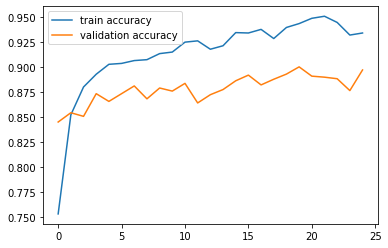

In [49]:
plt.plot(vgg_history.history['accuracy'], label='train accuracy')
plt.plot(vgg_history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

# Plotting loss vs validation loss

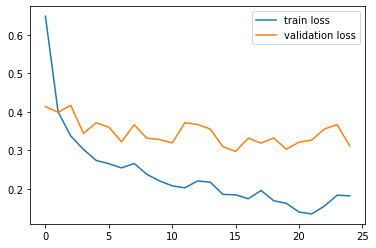

In [50]:
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

# Saving the model

In [51]:
model_name = 'VGG16_APPLE_LEAF_DISEASE_DETECTION_MODEL.h5'
save_dir = os.path.join(os.getcwd(),'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print("Saved the model")

Saved the model


In [52]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Loading the model

In [53]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("saved_models/VGG16_APPLE_LEAF_DISEASE_DETECTION_MODEL.h5")
print("Loaded model")
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
score = loaded_model.evaluate(x_valid,y_valid, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model
accuracy: 89.71%


# Predicting image 1

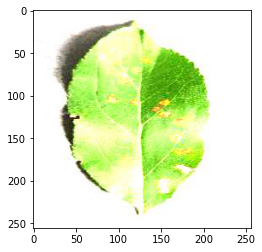

In [54]:
img_path1 = test_set_dir + "/"+"AppleCedarRust1.jpg"
img1 = plt.imread(img_path1)
plt.imshow(img1)
plt.show()

In [55]:
img1 = image.load_img(img_path1, target_size=(224, 224))
img_array1 = image.img_to_array(img1)
img_batch1 = np.expand_dims(img_array1, axis =0)
img_normalised1 = preprocess_input(img_batch1)
pred1 = loaded_model.predict(img_normalised1)
preds1 = pred1.argmax(axis = 1)
prediction1 = preds1.astype(int).flatten()
predictions1 = (lb.inverse_transform((prediction1)))
print(classes[predictions1])

['Apple___Cedar_apple_rust']


# Predicting image 2

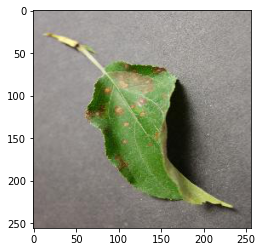

In [56]:
img_path2 = test_set_dir + "/"+"AppleCedarRust3.jpg"
img2 = plt.imread(img_path2)
plt.imshow(img2)
plt.show()

In [57]:
img2 = image.load_img(img_path2, target_size=(224, 224))
img_array2 = image.img_to_array(img2)
img_batch2 = np.expand_dims(img_array2, axis =0)
img_normalised2 = preprocess_input(img_batch2)
pred2 = loaded_model.predict(img_normalised2)
preds2 = pred2.argmax(axis = 1)
prediction2 = preds2.astype(int).flatten()
predictions2 = (lb.inverse_transform((prediction2)))
print(classes[predictions2])

['Apple___Cedar_apple_rust']


# Predicting image 3

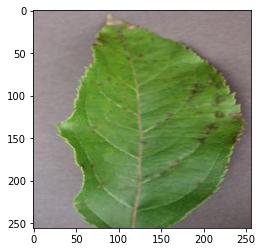

In [58]:
img_path3 = test_set_dir + "/"+"AppleScab1.jpg"
img3 = plt.imread(img_path3)
plt.imshow(img3)
plt.show()

In [59]:
img3 = image.load_img(img_path3, target_size=(224, 224))
img_array3 = image.img_to_array(img3)
img_batch3 = np.expand_dims(img_array3, axis =0)
img_normalised3 = preprocess_input(img_batch3)
pred3 = loaded_model.predict(img_normalised3)
preds3 = pred3.argmax(axis = 1)
prediction3 = preds3.astype(int).flatten()
predictions3 = (lb.inverse_transform((prediction3)))
print(classes[predictions3])

['Apple___Apple_scab']
